In [18]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split
import graphviz 

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import HalvingRandomSearchCV

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
data = pd.read_csv("tabela_final_treinamento.csv")

X = data.iloc[:, 0:225]
Y = data.iloc[:, -1]

In [ ]:
X

In [ ]:
Y

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [4]:
classfier = tree.DecisionTreeClassifier(random_state = 42)

In [ ]:
# Visualização das mudanças nas características da árvore conforme aumentamos o valor de ccp_alpha

In [6]:
path = classfier.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

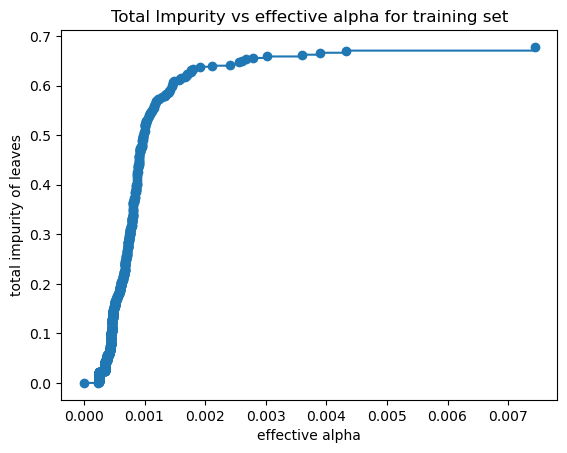

In [10]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [12]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.02197733752030151


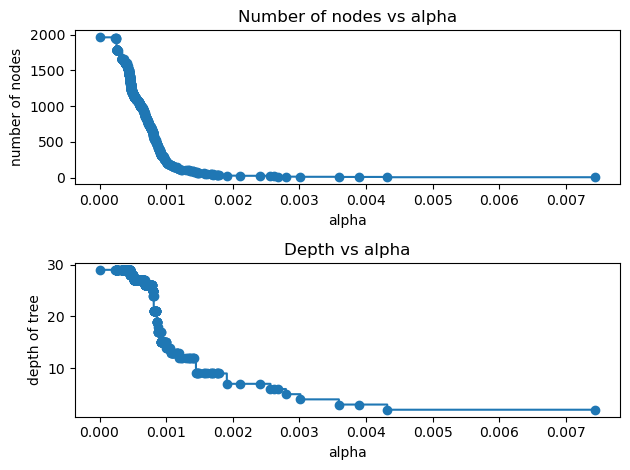

In [13]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

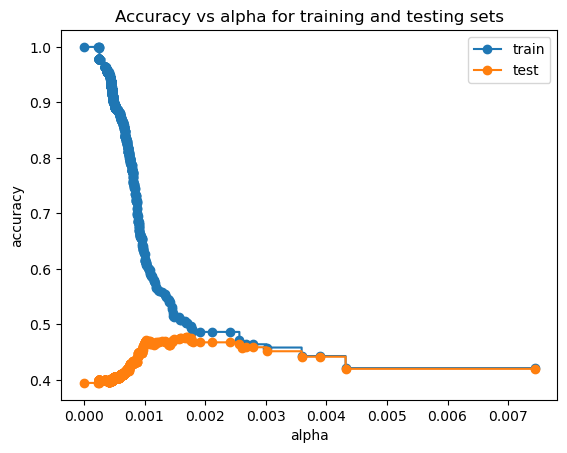

In [14]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:
# Término do experimento

In [5]:
classfier.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [ ]:
# Important parameters for HalvingGridSearchCV: param_grid (parameter's values of the estimator to test over the dataset), factor (3 -> selects the best 3 candidates parameters), agressive_elimination (True -> garantees that we will end up with factor candidates) and min_resources ('exhaust')
# Candidate = a parameter combination
# scoring = 'f1_score' ('accuracy_score' is set by default)
# Separate data to the HalvingGridSearchCV and for the test of the result of it
# error_score=0 -> prevents the search to fail during the process
# cv is set to 5 by default, using StratifiedKFold (used Kfold keeping the classes percentage in each fold)
# parm_grid = {"criterion":['gini', 'entropy'],
#               "random_state": 42,
#               "min_impurity_decrease": [0.1, 0.2, 0.25]
#               "min_samples_leaf": [10, 30, 50],
#               "ccp_alpha": [0.001, 0.0015, 0.0017, 0.002]
                

In [24]:
# 0 -> score: 0.23~0.24
#param_grid = {"criterion":['gini', 'entropy'],
#              "random_state": [42],
#              "min_impurity_decrease": [0.1, 0.2, 0.25],
#              "min_samples_leaf": [10, 30, 50],
#              "ccp_alpha": [0.001, 0.0015, 0.0017, 0.002]}

In [6]:
# 1 -> score: 0.42(train) 0.44(test)
param_grid = {"criterion":['gini', 'entropy'],
              "min_samples_leaf": [10, 30, 50],
              "ccp_alpha": [0.001, 0.0015, 0.0017, 0.002]}

In [84]:
# 2 -> score: 0.42(train e test)
param_grid = {"criterion":['gini', 'entropy'],
              "min_samples_leaf": [10, 30, 50]}

In [ ]:
search = HalvingGridSearchCV(classfier, param_grid, scoring="f1_weighted").fit(X_train, y_train) 

In [13]:
search.best_params_ 

{'ccp_alpha': 0.001, 'criterion': 'gini', 'min_samples_leaf': 50}

In [14]:
search.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.001, min_samples_leaf=50, random_state=42)

In [15]:
search.best_score_

0.41972714571300773

In [11]:
search.score(X_test, y_test)

0.4357828482563797

In [ ]:
# Matriz de Confusão

In [16]:
y_pred = search.predict(X_test)

In [17]:
y_pred

array([5, 3, 3, ..., 3, 2, 3])

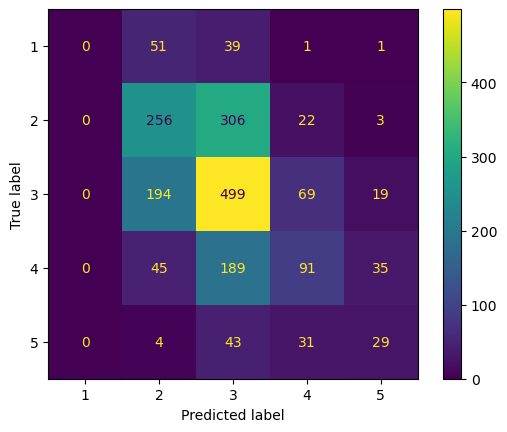

In [19]:
cm = confusion_matrix(y_test, y_pred, labels=search.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=search.classes_)
disp.plot()
plt.show()